# Modelo de Classificação de Intenções com CNN e LSTM

Este notebook implementa uma rede neural para classificar a intenção de um usuário (`intent`) em uma categoria de serviço (`service_name`) com base em uma frase de entrada.

A arquitetura do modelo combina:
- **Camadas Convolucionais (Conv1D)**: Para extrair características locais e n-gramas do texto.
- **Camadas Recorrentes (LSTM)**: Para entender o contexto e as dependências sequenciais nas características extraídas.

### 1. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, 
                                      Bidirectional, Input, GlobalMaxPooling1D, 
                                      GlobalAveragePooling1D, Concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import re

### 2. Carregamento e Pré-processamento dos Dados

Carregamos o arquivo CSV, definimos o delimitador e separamos as colunas de entrada (`intent`) e de alvo (`service_name`).

In [2]:
# O caminho para o CSV de TREINAMENTO é relativo à localização deste notebook
# csv_path_train = '../../../assets/intents_generated.csv'
csv_path_train = 'intents_generated_2.csv'

df_train = pd.read_csv(csv_path_train, delimiter=';')

# Remover linhas com valores ausentes
df_train.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o treino
intents_train = df_train['intent'].values
service_names_train = df_train['service_name'].values

print("Dados de Treinamento Carregados:")
df_train.head()

Dados de Treinamento Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,até quando posso comprar
1,1,Consulta Limite / Vencimento do cartão / Melho...,checar limite do cartão por favor
2,1,Consulta Limite / Vencimento do cartão / Melho...,consigo consultar meu limite agora
3,1,Consulta Limite / Vencimento do cartão / Melho...,consulta de limite disponível urgente
4,1,Consulta Limite / Vencimento do cartão / Melho...,consulta de limite do meu cartão


### 2.1. Normalização do Texto

Para melhorar a qualidade dos dados, vamos normalizar o texto removendo pontuações excessivas e convertendo para minúsculas.

In [3]:
# O caminho para o CSV de AVALIAÇÃO é relativo à localização deste notebook
csv_path_test = 'intents_pre_loaded.csv'

df_test = pd.read_csv(csv_path_test, delimiter=';')

# Remover linhas com valores ausentes
df_test.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o teste
intents_test = df_test['intent'].values
service_names_test = df_test['service_name'].values

print("\nDados de Avaliação Carregados:")
df_test.head()


Dados de Avaliação Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,Quanto tem disponível para usar
1,1,Consulta Limite / Vencimento do cartão / Melho...,quando fecha minha fatura
2,1,Consulta Limite / Vencimento do cartão / Melho...,Quando vence meu cartão
3,1,Consulta Limite / Vencimento do cartão / Melho...,quando posso comprar
4,1,Consulta Limite / Vencimento do cartão / Melho...,vencimento da fatura


In [14]:
def normalize_text(text):
    """Normaliza o texto removendo pontuação excessiva e convertendo para minúsculas"""
    text = str(text).lower()
    # Remove múltiplos espaços
    text = re.sub(r'\s+', ' ', text)
    # Remove pontuação no final
    text = re.sub(r'[!?.,;:]+$', '', text)
    return text.strip()

# Aplicar normalização aos dados de treino e teste
intents_train = np.array([normalize_text(x) for x in intents_train])
intents_test = np.array([normalize_text(x) for x in intents_test])

print("Exemplos de textos normalizados:")
print(intents_train[:3])

Exemplos de textos normalizados:
['até quando posso comprar' 'checar limite do cartão por favor'
 'consigo consultar meu limite agora']


### 3. Codificação dos Rótulos (Labels)

As redes neurais trabalham com números. Usamos o `LabelEncoder` para converter os nomes dos serviços (texto) em números inteiros.

In [5]:
# Combinar todos os rótulos para garantir que o LabelEncoder conheça todas as classes
all_service_names = np.concatenate([service_names_train, service_names_test])

label_encoder = LabelEncoder()
label_encoder.fit(all_service_names)

# Codificar os rótulos de treino e de teste
y_train_encoded = label_encoder.transform(service_names_train)
y_test_encoded = label_encoder.transform(service_names_test)

num_classes = len(label_encoder.classes_)

print(f"Número de classes de serviço: {num_classes}")
print(f"Exemplo de rótulo de treino codificado: {y_train_encoded[:5]}")
print(f"Exemplo de rótulo de teste codificado: {y_test_encoded[:5]}")

Número de classes de serviço: 16
Exemplo de rótulo de treino codificado: [2 2 2 2 2]
Exemplo de rótulo de teste codificado: [2 2 2 2 2]


### 4. Tokenização e Padding

O texto é convertido em sequências de números (`Tokenização`) e, em seguida, todas as sequências são padronizadas para ter o mesmo comprimento (`Padding`).

In [6]:
# Configurações aprimoradas
max_length = 40    # Aumentado para capturar frases mais longas
embedding_dim = 128 # Aumentado para vetores mais ricos
vocab_size_limit = 20000  # Limite para evitar overfitting

# Criar e treinar o tokenizer com os dados de TREINO
tokenizer = Tokenizer(num_words=vocab_size_limit, oov_token="<unk>")
tokenizer.fit_on_texts(intents_train)

# Tamanho real do vocabulário (limitado ou total)
vocab_size = min(len(tokenizer.word_index) + 1, vocab_size_limit)

# Converter textos de treino para sequências de inteiros
X_train_sequences = tokenizer.texts_to_sequences(intents_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')

# Converter textos de teste para sequências de inteiros
X_test_sequences = tokenizer.texts_to_sequences(intents_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Tamanho máximo das sequências: {max_length}")
print(f"Dimensão dos embeddings: {embedding_dim}")

Tamanho do vocabulário: 506
Tamanho máximo das sequências: 40
Dimensão dos embeddings: 128


### 6. Construção do Modelo Aprimorado (CNN + LSTM + Attention)

Modelo com arquitetura mais robusta:
- Múltiplas camadas convolucionais com diferentes tamanhos de kernel
- LSTM bidirecional com `return_sequences=True`
- Pooling global (Max + Average) para capturar características importantes
- Camadas densas com regularização

In [7]:
# Modelo funcional com arquitetura aprimorada
inp = Input(shape=(max_length,), dtype='int32')

# Camada de Embedding
emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(inp)

# Primeira camada convolucional
conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(emb)
conv1 = MaxPooling1D(pool_size=2)(conv1)

# Segunda camada convolucional
conv2 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)

# Dropout para regularização
drop1 = Dropout(0.3)(conv2)

# LSTM Bidirecional com return_sequences para pooling
lstm = Bidirectional(LSTM(128, return_sequences=True))(drop1)

# Combinar Global Max Pooling e Global Average Pooling
pool_max = GlobalMaxPooling1D()(lstm)
pool_avg = GlobalAveragePooling1D()(lstm)
concat = Concatenate()([pool_max, pool_avg])

# Camadas densas
dense1 = Dense(128, activation='relu')(concat)
drop2 = Dropout(0.4)(dense1)

# Camada de saída
out = Dense(num_classes, activation='softmax')(drop2)

# Criar o modelo
model = Model(inputs=inp, outputs=out)

# Compilar com taxa de aprendizado customizada
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 128)   │     64,768 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 128)   │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 128)   │     82,048 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 128)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 256)   │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 526,992 (2.01 MB)

 Trainable params: 526,992 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

### 7. Treinamento do Modelo com Callbacks Avançados

Callbacks utilizados:
- **EarlyStopping**: Para interromper quando não houver melhora
- **ReduceLROnPlateau**: Reduz a taxa de aprendizado quando a perda estabiliza
- **ModelCheckpoint**: Salva o melhor modelo automaticamente

Também utilizamos **class weights** para balancear classes desbalanceadas.

In [8]:
# Calcular class weights para balancear classes desbalanceadas
classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
class_weights = dict(zip(classes, class_weights_array))

print(f"Class weights calculados para {len(class_weights)} classes")

# Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_v4.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Treinar o modelo
history = model.fit(
    X_train_padded,
    y_train_encoded,
    validation_data=(X_test_padded, y_test_encoded),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights,
    verbose=2
)

Class weights calculados para 16 classes
Epoch 1/50

Epoch 1: val_loss improved from None to 2.77219, saving model to best_model_v4.h5


21/21 - 3s - 148ms/step - accuracy: 0.0528 - loss: 2.7755 - val_accuracy: 0.0538 - val_loss: 2.7722 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 2.77219 to 2.75307, saving model to best_model_v4.h5


21/21 - 0s - 21ms/step - accuracy: 0.0839 - loss: 2.7679 - val_accuracy: 0.1075 - val_loss: 2.7531 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 2.75307 to 2.54886, saving model to best_model_v4.h5


21/21 - 0s - 22ms/step - accuracy: 0.1910 - loss: 2.5793 - val_accuracy: 0.1398 - val_loss: 2.5489 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 2.54886 to 2.18994, saving model to best_model_v4.h5


21/21 - 0s - 19ms/step - accuracy: 0.2407 - loss: 2.2680 - val_accuracy: 0.2043 - val_loss: 2.1899 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 2.18994 to 1.92060, saving model to best_model_v4.h5


21/21 - 0s - 20ms/step - accuracy: 0.3339 - loss: 2.0116 - val_accuracy: 0.3118 - val_loss: 1.9206 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss improved from 1.92060 to 1.71501, saving model to best_model_v4.h5


21/21 - 0s - 22ms/step - accuracy: 0.3804 - loss: 1.7257 - val_accuracy: 0.3978 - val_loss: 1.7150 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss improved from 1.71501 to 1.53015, saving model to best_model_v4.h5


21/21 - 0s - 21ms/step - accuracy: 0.4627 - loss: 1.5091 - val_accuracy: 0.4086 - val_loss: 1.5301 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss improved from 1.53015 to 1.51778, saving model to best_model_v4.h5


21/21 - 0s - 21ms/step - accuracy: 0.5217 - loss: 1.3092 - val_accuracy: 0.5054 - val_loss: 1.5178 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss improved from 1.51778 to 1.39845, saving model to best_model_v4.h5


21/21 - 0s - 21ms/step - accuracy: 0.5606 - loss: 1.1475 - val_accuracy: 0.5161 - val_loss: 1.3985 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss did not improve from 1.39845
21/21 - 0s - 17ms/step - accuracy: 0.6444 - loss: 0.9525 - val_accuracy: 0.5484 - val_loss: 1.4422 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 1.39845
21/21 - 0s - 16ms/step - accuracy: 0.7345 - loss: 0.8423 - val_accuracy: 0.5914 - val_loss: 1.4226 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_loss did not improve from 1.39845
21/21 - 0s - 19ms/step - accuracy: 0.7220 - loss: 0.7903 - val_accuracy: 0.6129 - val_loss: 1.4053 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_loss did not improve from 1.39845
21/21 - 0s - 20ms/step - accuracy: 0.7453 - loss: 0.7352 - val_accuracy: 0.5914 - val_loss: 

21/21 - 0s - 21ms/step - accuracy: 0.8152 - loss: 0.6039 - val_accuracy: 0.6452 - val_loss: 1.3370 - learning_rate: 2.5000e-04
Epoch 15/50

Epoch 15: val_loss did not improve from 1.33697
21/21 - 0s - 18ms/step - accuracy: 0.8307 - loss: 0.5209 - val_accuracy: 0.6667 - val_loss: 1.3678 - learning_rate: 2.5000e-04
Epoch 16/50

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: val_loss did not improve from 1.33697
21/21 - 0s - 18ms/step - accuracy: 0.8494 - loss: 0.4883 - val_accuracy: 0.6989 - val_loss: 1.4048 - learning_rate: 2.5000e-04
Epoch 17/50

Epoch 17: val_loss did not improve from 1.33697
21/21 - 0s - 18ms/step - accuracy: 0.8835 - loss: 0.4307 - val_accuracy: 0.6882 - val_loss: 1.3640 - learning_rate: 1.2500e-04
Epoch 18/50

Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 18: val_loss did not improve from 1.33697
21/21 - 0s - 17ms/step - accuracy: 0.8820 - loss: 0.4199 - val_accuracy: 0.6989 - val_loss: 1

### 8. Avaliação do Modelo

In [9]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"\nAcurácia no conjunto de teste: {accuracy:.4f}")


Acurácia no conjunto de teste: 0.6452


### 8.1. Matriz de Confusão

Para visualizar o desempenho do modelo em mais detalhes, geramos uma matriz de confusão. Ela mostra quais classes estão sendo confundidas umas com as outras.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Relatório de Classificação:

                                                               precision    recall  f1-score   support

                                           Atendimento humano       1.00      0.60      0.75         5
                                       Cancelamento de cartão       0.50      0.40      0.44         5
Consulta Limite / Vencimento do cartão / Melhor dia de compra       1.00      0.33      0.50         6
                                            Consulta do Saldo       0.75      1.00      0.86         6
                                        Desbloqueio de Cartão       0.38      0.50      0.43         6
                              Esqueceu senha / Troca de senha       0.86      1.00      0.92         6
                                          Pagamento de contas       0.00      0.00      0.00         5
                                                Perda e roubo       0.25      0.17      0.20         6
    

d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

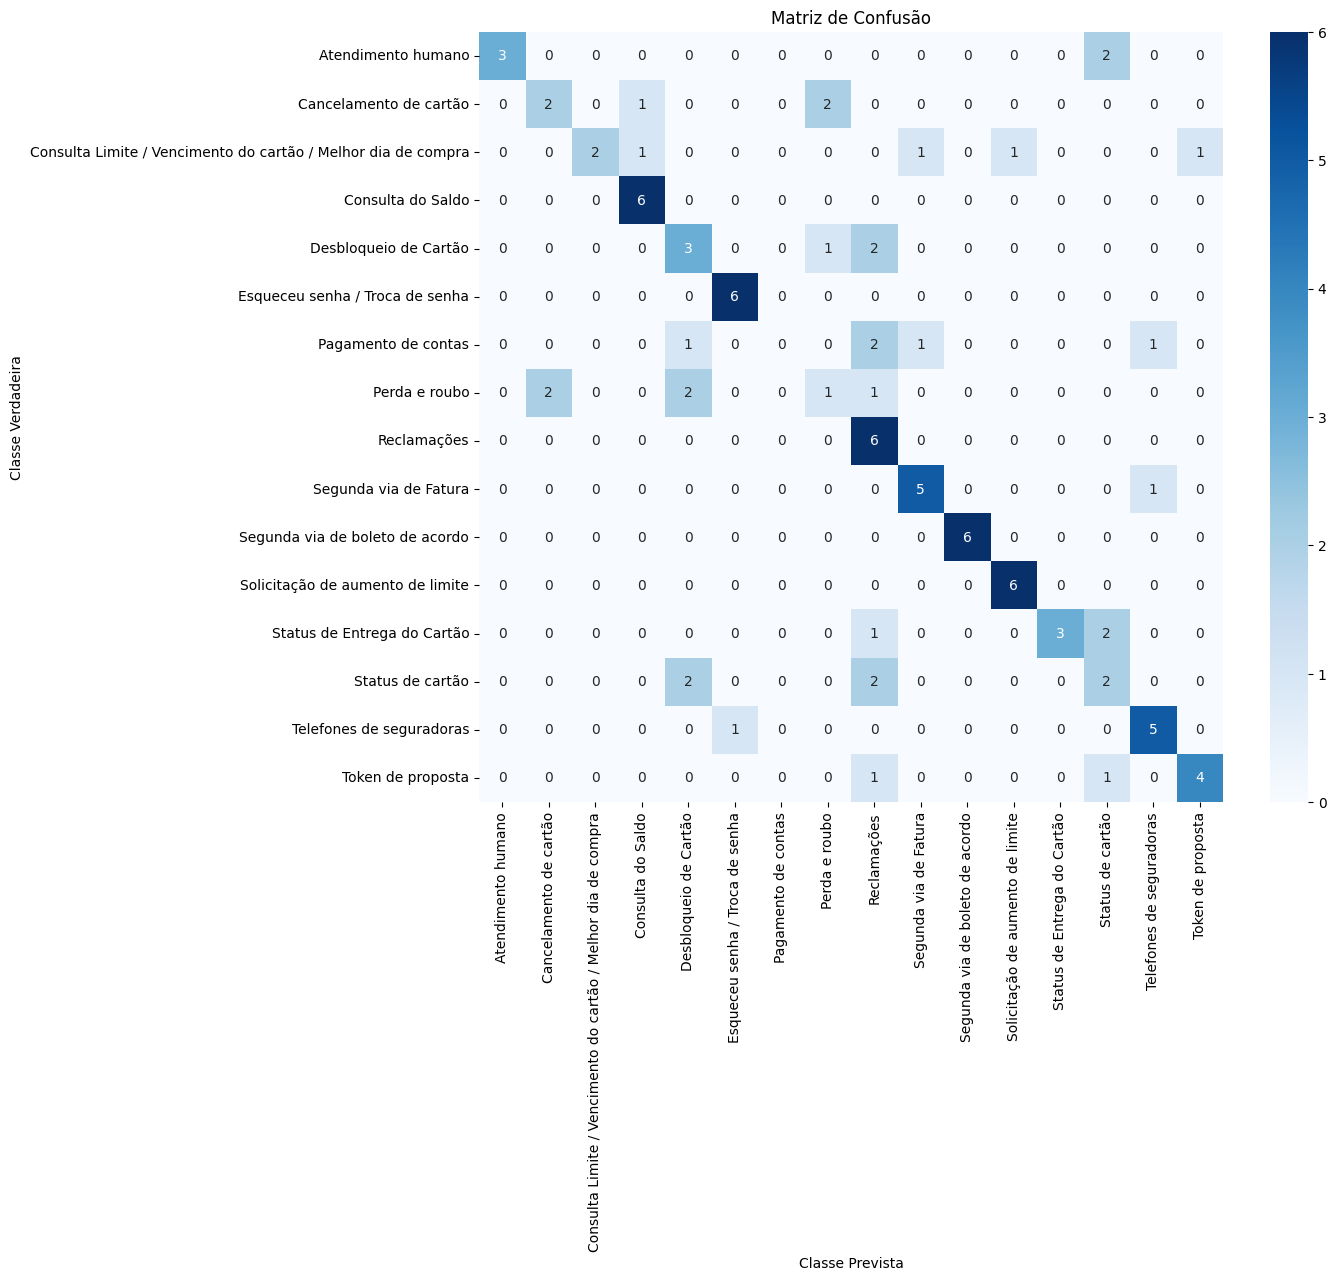

In [10]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nomes das classes para os eixos
class_names = label_encoder.classes_

# Imprimir o relatório de classificação
print("Relatório de Classificação:\n")
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

# Gerar a matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

### 8.2. Gráficos de Treinamento

Para entender melhor o comportamento do modelo durante o treinamento, podemos plotar a acurácia e a perda (loss) ao longo das épocas.

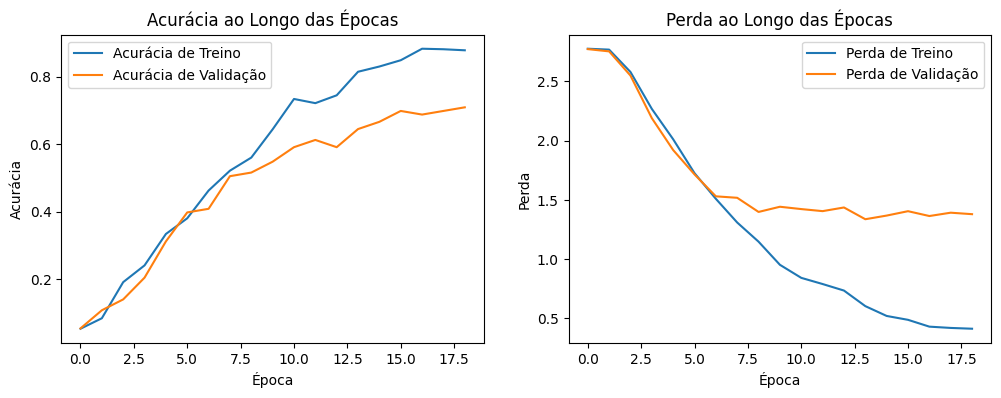

In [11]:
# Plotar o histórico de treinamento
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

### 9. Função para Predição

Criamos uma função auxiliar para encapsular todo o processo de pré-processamento e predição para uma nova frase.

In [12]:
def predict_service(text):
    # Pré-processar o texto de entrada
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Fazer a predição
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction)

    # Decodificar o resultado para o nome do serviço
    predicted_service_name = label_encoder.inverse_transform([predicted_class_index])

    return predicted_service_name[0]

### 10. Teste do Modelo com Novas Frases

In [13]:
# Save the model
model.save('service_intent_model_5.h5')

### 11. Geração de Dados Sintéticos (Opcional)

Para aumentar a robustez do modelo, podemos gerar dados sintéticos. A célula abaixo cria um novo arquivo CSV com 100 exemplos de frases para cada categoria de serviço, totalizando 1600 novas amostras.

**Atenção**: Execute esta célula apenas uma vez para criar o arquivo.

In [16]:
import pandas as pd
import random
import os

# Dicionário com os serviços e templates de frases
services_data = {
    "Consulta Limite / Vencimento do cartão / Melhor dia de compra": [
        "qual o limite do meu cartão?", "quanto ainda tenho de limite?", "meu limite disponível",
        "quando vence minha fatura?", "qual a data de vencimento?", "vencimento da fatura",
        "melhor dia para comprar", "qual o melhor dia de compra?", "dia bom para usar o cartão"
    ],
    "Segunda via de boleto de acordo": [
        "preciso da segunda via do meu acordo", "gerar boleto da negociação", "não recebi o boleto do acordo",
        "enviar novamente o boleto do meu parcelamento", "código de barras do acordo", "pagar meu acordo"
    ],
    "Segunda via de Fatura": [
        "quero a segunda via da minha fatura", "me envia o boleto da fatura, por favor", "não achei minha fatura",
        "preciso do código de barras para pagar a fatura", "gerar fatura em PDF", "fatura detalhada"
    ],
    "Status de Entrega do Cartão": [
        "gostaria de saber onde está meu cartão", "qual o status da entrega do meu cartão?", "meu cartão já foi enviado?",
        "rastrear entrega do cartão", "previsão de chegada do cartão", "ainda não recebi meu cartão"
    ],
    "Status de cartão": [
        "meu cartão foi bloqueado?", "qual o status do meu cartão?", "o cartão está ativo para uso?",
        "não consigo usar meu cartão", "minha compra foi recusada", "verificar status do cartão"
    ],
    "Solicitação de aumento de limite": [
        "gostaria de pedir um aumento de limite", "como faço para ter mais limite?", "solicitar mais crédito",
        "aumentar o limite do meu cartão de crédito", "meu limite é baixo, posso aumentar?", "quero um limite maior"
    ],
    "Cancelamento de cartão": [
        "quero cancelar meu cartão", "como faço para cancelar o cartão?", "não quero mais ter este cartão",
        "encerrar minha conta do cartão", "cancelar o cartão de crédito", "desativar meu cartão permanentemente"
    ],
    "Telefones de seguradoras": [
        "qual o telefone do seguro do cartão?", "preciso do contato da seguradora", "como falo com o seguro?",
        "número para acionar o seguro", "cancelar seguro do cartão", "informações sobre a apólice de seguro"
    ],
    "Desbloqueio de Cartão": [
        "recebi meu cartão e quero desbloquear", "como desbloquear o cartão novo?", "desbloquear meu cartão agora",
        "ativar o cartão para compras", "meu cartão chegou, como ativo?", "quero usar meu cartão novo"
    ],
    "Esqueceu senha / Troca de senha": [
        "esqueci a senha do meu cartão, e agora?", "preciso cadastrar uma nova senha", "como altero a senha do cartão?",
        "não lembro minha senha", "quero trocar a senha", "ajuda para recuperar a senha"
    ],
    "Perda e roubo": [
        "perdi meu cartão, preciso bloquear", "fui roubado, levem meu cartão", "bloquear cartão por perda",
        "meu cartão foi furtado", "comunicar roubo de cartão", "extraviei meu cartão, o que fazer?"
    ],
    "Consulta do Saldo": [
        "qual o saldo da minha conta?", "gostaria de ver meu saldo", "quanto dinheiro eu tenho?",
        "consultar o extrato da conta", "verificar meu saldo atual", "meu saldo por favor"
    ],
    "Pagamento de contas": [
        "quero pagar uma conta de consumo", "pagar um boleto com a câmera", "agendar pagamento de conta",
        "realizar pagamento de boleto", "como pagar contas pelo app?", "pagar fatura de água"
    ],
    "Reclamações": [
        "gostaria de fazer uma reclamação", "quero registrar uma queixa sobre o atendimento", "não estou satisfeito com o serviço",
        "abrir um protocolo de reclamação", "reclamar sobre uma cobrança indevida", "tenho uma queixa"
    ],
    "Atendimento humano": [
        "preciso falar com um atendente", "quero ser transferido para uma pessoa", "falar com um especialista",
        "me ajuda a falar com um humano", "não quero falar com robô", "atendimento com uma pessoa, por favor"
    ],
    "Token de proposta": [
        "qual o token da minha proposta?", "não recebi o código do meu cartão", "informar token para finalizar a proposta",
        "cadê o número do token?", "preciso do token para continuar", "validar proposta com token"
    ]
}

# Gerar os dados
generated_data = []
for service, templates in services_data.items():
    for _ in range(100):
        intent = random.choice(templates)
        # Adicionar pequenas variações
        if random.random() > 0.7:
            intent = intent.replace("?", "").strip()
        if random.random() > 0.8:
            intent = "por favor, " + intent
        if random.random() > 0.9:
            intent = intent.upper()
            
        generated_data.append({"intent": intent, "service_name": service})

# Criar DataFrame
df_generated = pd.DataFrame(generated_data)

# Caminho para salvar o arquivo
output_path = 'intents_generated.csv'

# Criar o diretório se não existir
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Salvar em CSV
df_generated.to_csv(output_path, sep=';', index=False, encoding='utf-8-sig')

print(f"Arquivo '{output_path}' criado com {len(df_generated)} linhas.")
df_generated.head()

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: ''

In [ ]:
import pandas as pd

# Caminho para o arquivo CSV
file_path = r'd:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\training\intents_generated_2.csv'

try:
    # Ler o arquivo CSV usando pandas
    df = pd.read_csv(file_path, delimiter=';')

    # Contar as linhas antes da remoção
    initial_rows = len(df)
    print(f"Número de linhas antes da remoção: {initial_rows}")

    # Remover linhas duplicadas
    df_deduplicated = df.drop_duplicates()

    # Contar as linhas após a remoção
    final_rows = len(df_deduplicated)
    print(f"Número de linhas após a remoção: {final_rows}")

    # Salvar o DataFrame de volta no arquivo CSV
    df_deduplicated.to_csv(file_path, sep=';', index=False, encoding='utf-8-sig')

    print(f"\nArquivo '{file_path}' atualizado com sucesso.")
    print(f"{initial_rows - final_rows} linhas duplicadas foram removidas.")

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")